### Load data

In [17]:
!pip install sentence_transformers

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
warnings.filterwarnings('ignore')

In [ ]:
full_df = pd.read_csv("/content/drive/MyDrive/DS301/metadata.csv")
dfs = []
for year in range(2019, 2021):
    df = pd.read_csv(f"/content/drive/MyDrive/DS301/deduplicated_dataset_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

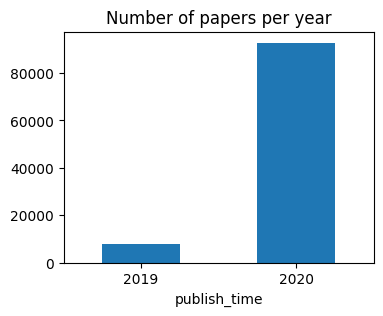

In [ ]:
# Plot the number of papers per year
df.groupby("publish_time").count()["cord_uid"].plot(kind="bar",
    title="Number of papers per year", figsize=(4, 3))
plt.xticks(rotation=0)
plt.show()

### Embedding

In [ ]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3147 [00:00<?, ?it/s]

In [ ]:
df['Embeddings'] = list(embeddings)

In [ ]:
# df.to_csv('/content/drive/MyDrive/DS301/embeddings.csv')

### 2019 LDA

In [6]:
year = 2019
df = pd.read_csv("/content/drive/MyDrive/DS301/embeddings.csv")
df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2019 with 7883 samples...


In [7]:
df_year.head()

,Unnamed: 0,cord_uid,title,publish_time,language,abstract,Embeddings
0,0,l2d0mwsr,Endovascular treatment of debilitating tinnitu...,2019,en,BACKGROUND AND OBJECTIVE Pulsatile tinnitus (P...,[ 1.92286242e-02 -7.71822259e-02 1.81762651e-...
1,1,od684vu5,A Scoping Review of Validated Tools to Measure...,2019,en,OBJECTIVE To identify and compare validated to...,[ 4.92482632e-02 3.20984907e-02 6.31543528e-...
2,2,3cnamu29,17α-Hydroxyprogesterone Caproate and the Risk ...,2019,en,OBJECTIVE To evaluate whether 17α-hydroxyproge...,[-1.16664041e-02 -1.10433176e-02 -2.60336641e-...
3,3,jhs2u33l,The effects of exercise on lipid profile and b...,2019,en,Exercise is commonly prescribed to improve lip...,[ 4.68276395e-03 8.40257562e-04 6.49902876e-...
4,4,zhta1788,Comparison of vocal cord view between neutral ...,2019,en,BACKGROUND In intubation using fiberoptic bron...,[ 1.03576249e-02 -5.98131120e-02 -1.95771246e-...


In [13]:
# # Concat embeddings to dataframe
# embedding_df = np.stack(df_year.Embeddings.tolist())
# print(embedding_df.shape)

In [14]:
# # Perform PCA
# pca = PCA(n_components=0.90)
# embedding_pca = pca.fit_transform(df_year)
# print(f"Reduced {df_year.shape[1]} to {embedding_pca.shape[1]} dimensions.")

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import re

# Load data
year = 2019
df = pd.read_csv("/content/drive/MyDrive/DS301/embeddings.csv")

# Filter for the year 2019
df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

# Filter for English abstracts from the year 2019
df_english_only_2019 = df_year[df_year['language'] == 'en']

# Preprocess Text Data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply preprocessing to the 2019 subset
df_english_only_2019['abstract_clean'] = df_english_only_2019['abstract'].apply(preprocess_text)

# Create a Document-Term Matrix for the 2019 subset
vectorizer = CountVectorizer(stop_words='english')
dtm_2019 = vectorizer.fit_transform(df_english_only_2019['abstract_clean'])

# Apply LDA to the 2019 subset
lda_2019 = LatentDirichletAllocation(n_components=5, random_state=0)
lda_2019.fit(dtm_2019)

# Review Topics for the 2019 subset
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_2019, vectorizer.get_feature_names_out(), no_top_words)

# Assign Documents to Topics for the 2019 subset
topic_values_2019 = lda_2019.transform(dtm_2019)
df_english_only_2019['Topic'] = topic_values_2019.argmax(axis=1)


Processing year 2019 with 7883 samples...
Topic 0:
patients studies results study methods treatment group ci outcomes included
Topic 1:
cells virus viral protein cell viruses infection host human expression
Topic 2:
virus infection study respiratory samples results viral group cells detected
Topic 3:
health data respiratory study disease influenza results infections research methods
Topic 4:
diseases health disease development review merscov use treatment used infectious


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7883 samples in 0.011s...
[t-SNE] Computed neighbors for 7883 samples in 0.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7883
[t-SNE] Computed conditional probabilities for sample 2000 / 7883
[t-SNE] Computed conditional probabilities for sample 3000 / 7883
[t-SNE] Computed conditional probabilities for sample 4000 / 7883
[t-SNE] Computed conditional probabilities for sample 5000 / 7883
[t-SNE] Computed conditional probabilities for sample 6000 / 7883
[t-SNE] Computed conditional probabilities for sample 7000 / 7883
[t-SNE] Computed conditional probabilities for sample 7883 / 7883
[t-SNE] Mean sigma: 0.000140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.504097
[t-SNE] KL divergence after 2500 iterations: 0.571592


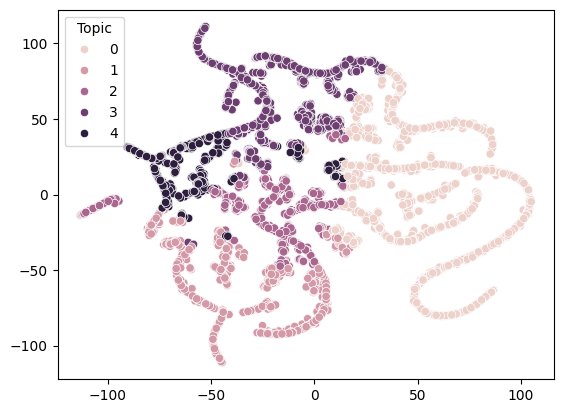

In [21]:
# Perform t-SNE for visualization (Optional)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, init='pca', n_iter=2500, perplexity=30, learning_rate=200)
tsne_lda = tsne_model.fit_transform(topic_values_2019)  # This can be a long process for large datasets

# Plot the t-SNE result
sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1], hue=df_english_only_2019['Topic'])
plt.show()
